# Single Pixel Study

- [MNIST](#MNIST)
- [CIFAR-10](#CIFAR-10)
- [OTHER](#OTHER)

In [1]:
from IPython.display import display
from ipywidgets import FloatProgress

import sys
sys.path.append('../src')

import neuralnetworkclassifier as nnc
import mlutils as ml
import perturb as per

import pickle, gzip
import numpy as np
import pandas as pd
import itertools
import copy
import pickle
import glob

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')

## MNIST

In [2]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

--2019-11-21 18:52:42--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz.2’

mnist.pkl.gz.2      100%[===================>]  15.42M  7.94MB/s    in 1.9s    

2019-11-21 18:52:45 (7.94 MB/s) - ‘mnist.pkl.gz.2’ saved [16168813/16168813]



In [3]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0].reshape(-1, 1, 28, 28)
Ttrain = train_set[1].reshape((-1, 1))

Xtest  = test_set[0].reshape(-1, 1, 28, 28)
Ttest  = test_set[1].reshape((-1, 1))

Xvalid = valid_set[0].reshape(-1, 1, 28, 28)
Tvalid = valid_set[1].reshape((-1, 1))

print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape, Xvalid.shape, Tvalid.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 1, 28, 28) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [5]:
nnet = nnc.NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                       image_size=Xtrain.shape[2],
                                       n_units_in_conv_layers=[10], 
                                       kernels_size_and_stride=[(7, 3)],
                                       max_pooling_kernels_and_stride=[(2, 2)],
                                       n_units_in_fc_hidden_layers=[],
                                       classes=np.unique(Ttrain), use_gpu=True)

nnet.train(Xtrain, Ttrain, n_epochs=50, batch_size=1500,
           optim='Adam', learning_rate=0.05, verbose=True)

Epoch 5 error 0.10912
Epoch 10 error 0.09920
Epoch 15 error 0.10045
Epoch 20 error 0.11776
Epoch 25 error 0.12282
Epoch 30 error 0.12792
Epoch 35 error 0.15016
Epoch 40 error 0.12793
Epoch 45 error 0.11041
Epoch 50 error 0.10349


In [6]:
nnet

NeuralNetwork_Convolutional(
                            n_channels_in_image=1,
                            image_size=28,
                            n_units_in_conv_layers=[10],
                            kernels_size_and_stride=[(7, 3)],
                            max_pooling_kernels_and_stride=[(2, 2)],
                            n_units_in_fc_hidden_layers=[],
                            classes=[0 1 2 3 4 5 6 7 8 9],
                            use_gpu=True)
Sequential(
  (conv_0): Conv2d(1, 10, kernel_size=(7, 7), stride=(3, 3))
  (output_0): Tanh()
  (pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (output_1): Linear(in_features=160, out_features=10, bias=True)
)
   Network was trained for 50 epochs with a batch size of 1500 and took 6.3388 seconds.
   Final objective value is 0.103

In [7]:
train_percent = ml.percent_correct(Ttrain, nnet.use(Xtrain)[0])

classes, Y    = nnet.use(Xtest)
test_percent  = ml.percent_correct(Ttest, classes)

print(f'Train Percentage: {train_percent:.3f}%, Test Percentage: {test_percent:.3f}%')

Train Percentage: 96.160%, Test Percentage: 95.480%


In [8]:
_ = ml.confusion_matrix(Ttest, classes, np.unique(Ttest))

       0    1    2    3    4    5    6    7    8    9
    ------------------------------------------------------------
 0 | 97.2  0    0.4  0.1  0.2  0.1  1.1  0.2  0.5  0.1
 1 |  0   99.0  0.2  0.4  0    0.1  0.1  0    0.3  0  
 2 |  0.3  1.1 92.5  1.3  0.7  0    0.2  1.1  2.9  0  
 3 |  0.2  0    0.6 97.4  0.1  0.1  0    0.5  1.0  0.1
 4 |  0    0.2  0.2  0   98.5  0    0.1  0.2  0.2  0.6
 5 |  0.3  0.1  0.2  3.9  0.2 90.4  1.1  0.1  3.5  0.1
 6 |  0.3  0.5  0    0.1  0.8  0.2 97.5  0    0.5  0  
 7 |  0.1  0.9  1.2  0.5  0.8  0    0   94.9  0.7  1.0
 8 |  0.4  0.2  0.1  0.9  0.8  0.2  0.3  0.7 96.1  0.2
 9 |  0.3  0.6  0.1  0.7  3.1  0    0    2.6  2.2 90.5


Total of 179 misclassified samples,
      with a 2.450% difference from test by changing 1 pixel(s)
(10000, 1, 28, 28) (10000, 1, 28, 28)


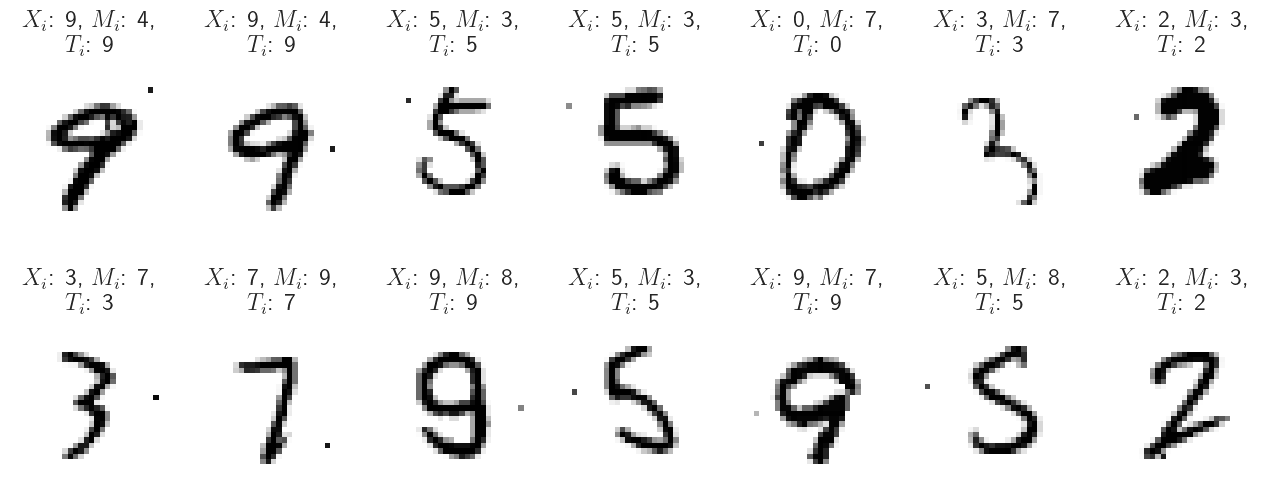

(10000, 1, 28, 28) (10000, 1, 28, 28)


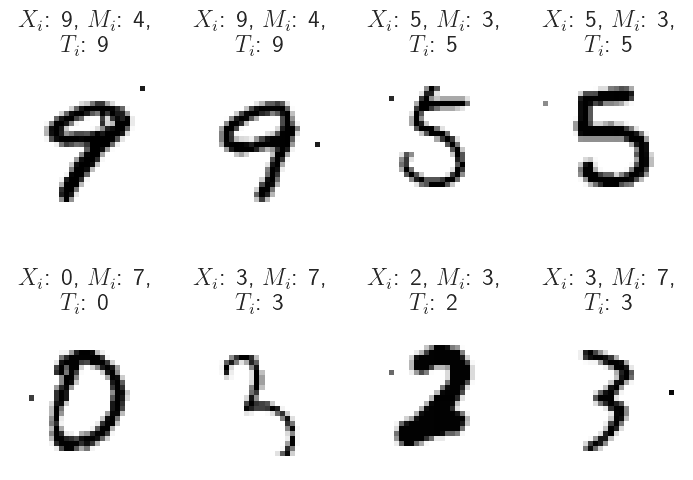

FloatProgress(value=0.0, max=375.0)

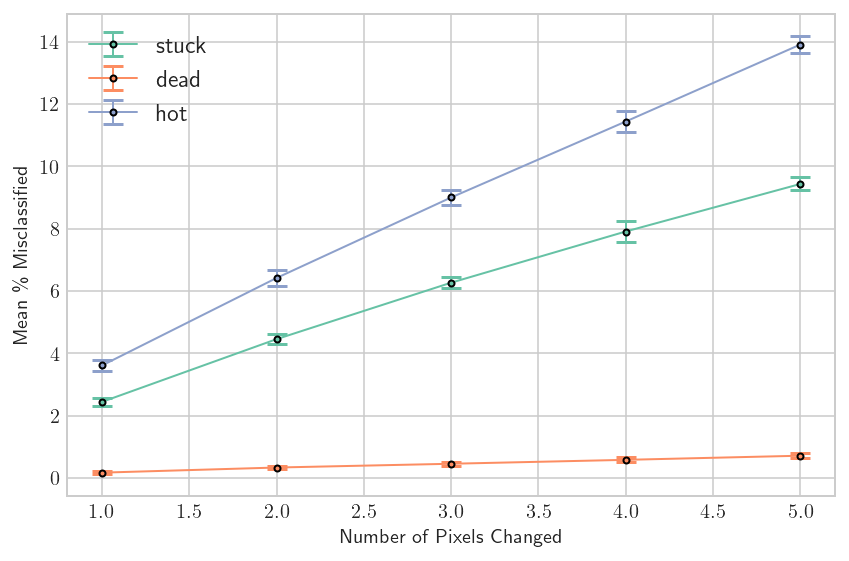

In [9]:
pixels_to_change = 1
Xcopy = per.change_pixel(Xtest, pixels_to_change=pixels_to_change)

diff_index, percent_diff = per.classified_diff(nnet, Xtest, Xcopy, Ttest)

print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by changing {pixels_to_change} pixel(s)''')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='MNIST', 
           name='media/mnist_example_single_1px.pdf')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='MNIST', 
           display='grid', name='media/mnist_example_grid_1px.pdf')

per.change_in_pixels_plot(nnet, Xtest, Ttest, end_pixel_val=5, 
                          trials_per_pixel=25, name='media/mnist_change_5px.pdf')

## CIFAR-10

In [10]:
!curl -O http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvf cifar-10-python.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  46.4M      0  0:00:03  0:00:03 --:--:-- 46.4M
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [11]:
def load(file_name):
    data = []
    
    for file in glob.glob('cifar-10-batches-py/' + file_name):
        with open(file, 'rb') as fo:
            data.append(pickle.load(fo, encoding='bytes'))
            
    images = np.array(data[0][b'data'])
    labels = np.array(data[0][b'labels'])

    if len(data) > 1:
        for i in range(1, len(data)):
            images = np.concatenate((images, data[i][b'data']), axis=0)
            labels = np.concatenate((labels, data[i][b'labels']), axis=0)
    
    return (images.reshape(-1, 3, 32, 32)/255.0).astype(np.float32), labels.reshape((-1, 1))

Xtrain, Ttrain = load('data_batch_*')
Xtest, Ttest, = load('test_batch')

print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape)
    
with open('cifar-10-batches-py/batches.meta', 'rb') as f:
    class_names = pickle.load(f, encoding='bytes')
class_names = class_names[b'label_names']

(50000, 3, 32, 32) (50000, 1) (10000, 3, 32, 32) (10000, 1)


In [12]:
import imp
imp.reload(nnc);

In [28]:
nnet = nnc.NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[128, 64, 64],
                                   kernels_size_and_stride=[(4, 2), (2, 1), (2, 1)],
                                   max_pooling_kernels_and_stride=[(2, 2), (2, 2), ()],
                                   n_units_in_fc_hidden_layers=[], 
                                   classes=np.unique(Ttrain), use_gpu=True)

nnet.train(Xtrain, Ttrain, n_epochs=100, batch_size=1500,
           optim='Adam', learning_rate=0.0004, verbose=True)

Epoch 10 error 1.16042
Epoch 20 error 0.96773
Epoch 30 error 0.87261
Epoch 40 error 0.80681
Epoch 50 error 0.75276
Epoch 60 error 0.70549
Epoch 70 error 0.66517
Epoch 80 error 0.63013
Epoch 90 error 0.59858
Epoch 100 error 0.57029


In [29]:
nnet

NeuralNetwork_Convolutional(
                            n_channels_in_image=3,
                            image_size=32,
                            n_units_in_conv_layers=[128, 64, 64],
                            kernels_size_and_stride=[(4, 2), (2, 1), (2, 1)],
                            max_pooling_kernels_and_stride=[(2, 2), (2, 2), ()],
                            n_units_in_fc_hidden_layers=[],
                            classes=[0 1 2 3 4 5 6 7 8 9],
                            use_gpu=True)
Sequential(
  (conv_0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2))
  (output_0): Tanh()
  (pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_1): Conv2d(128, 64, kernel_size=(2, 2), stride=(1, 1))
  (output_1): Tanh()
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (output_2): Tanh()
  (flatten): Flatten()
  (output_3): Linear(in_features

In [30]:
train_percent = ml.percent_correct(Ttrain, nnet.use(Xtrain)[0])

classes, Y    = nnet.use(Xtest)
test_percent  = ml.percent_correct(Ttest, classes)

print(f'Train Percentage: {train_percent:.3f}%, Test Percentage: {test_percent:.3f}%')

Train Percentage: 80.716%, Test Percentage: 70.160%


Total of 101 misclassified samples,
      with a 2.790% difference from test by changing 1 pixel(s)
(10000, 3, 32, 32) (10000, 3, 32, 32)


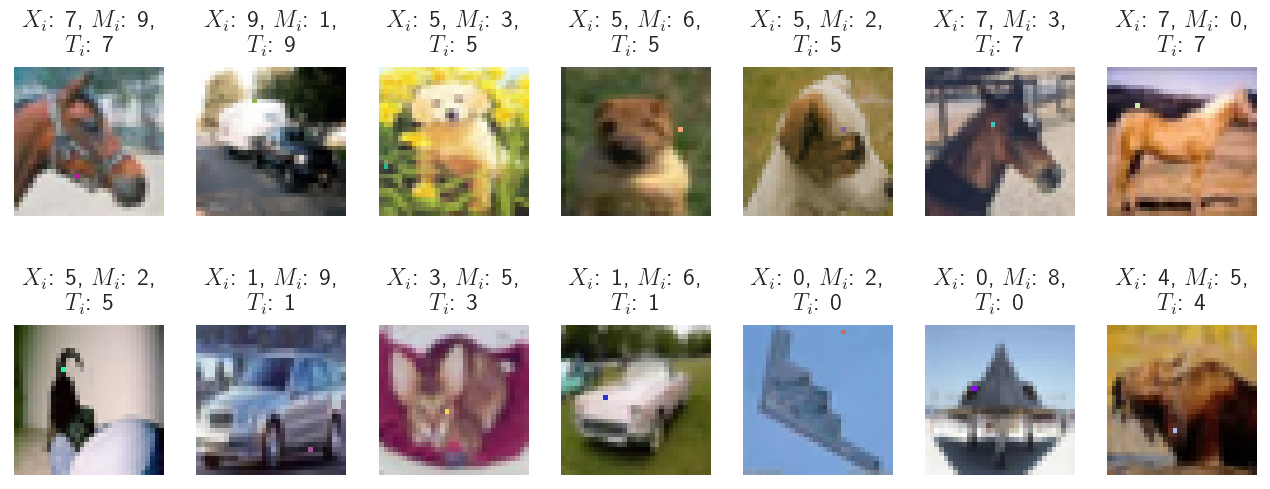

(10000, 3, 32, 32) (10000, 3, 32, 32)


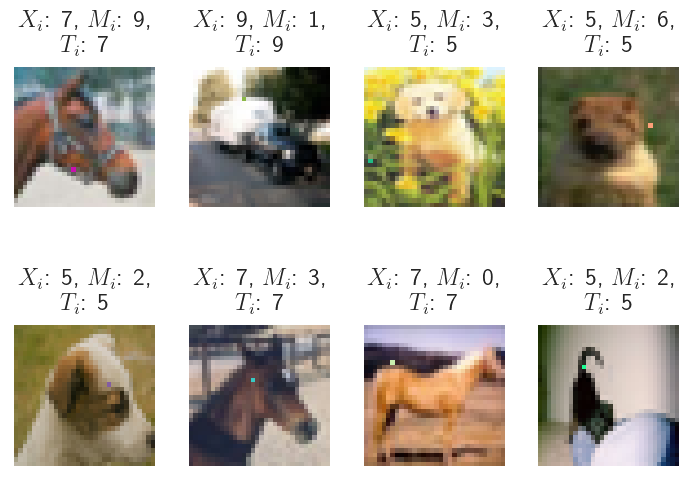

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


FloatProgress(value=0.0, max=375.0)

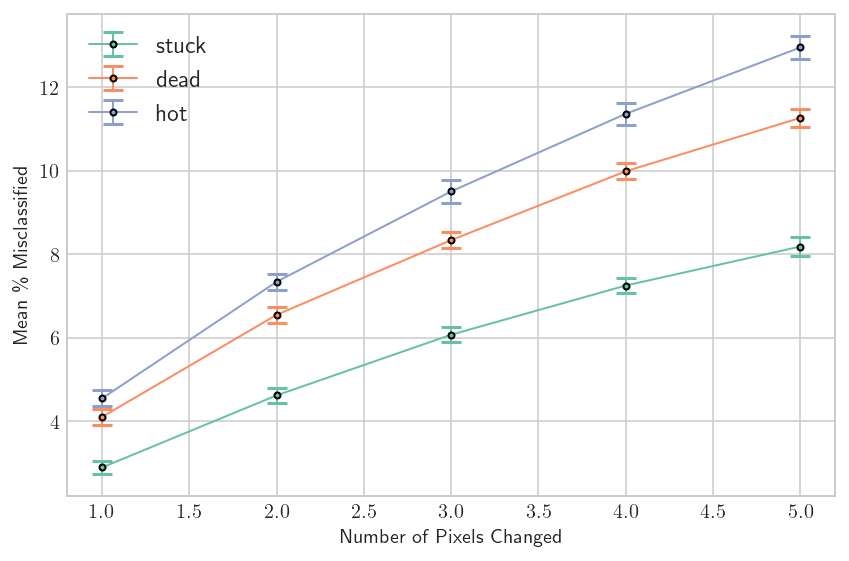

In [31]:
pixels_to_change = 1
Xcopy = per.change_pixel(Xtest, pixels_to_change=pixels_to_change)

diff_index, percent_diff = per.classified_diff(nnet, Xtest, Xcopy, Ttest)

print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by changing {pixels_to_change} pixel(s)''')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='CIFAR',
           name='media/cifar_example_single_1px_stuck.pdf')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='CIFAR',
           display='grid', name='media/cifar_example_grid_1px_stuck.pdf')

print(class_names)

per.change_in_pixels_plot(nnet, Xtest, Ttest, end_pixel_val=5, 
                          trials_per_pixel=25, name='media/cifar_change_5px_stuck.pdf')

## OTHER